In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [3]:
#format_plots()
#format_pizza_plots()
c = PlotConfig()
saver = save_factory(c.dana_save_path / "age_vs_behavioral_age", tight_layout=False)

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_v2.parquet')
df_age = pd.read_parquet(path)

In [6]:
## update data
def remove_crl(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    #df.drop('m05_c02_b01_s01', level=1, axis=0, inplace=True)
    #df.drop('a85e0616-6a5b-4dd8-a2d6-51701084c25e',level=3, axis=0, inplace=True)
    #df.drop('b365ea6a-369f-4991-b139-15694dc1c86d',level=3, axis=0, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [7]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='cubehelix', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    c = PlotConfig()
    fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_decoder_confusion_pre.pdf')

In [8]:
# choose a model for decoder
clf = KNeighborsRegressor(n_neighbors=5)

# choose cross validation scheme
cv = LeaveOneOut()

#number of iterations for shuffle
it=1000

In [9]:
# process data

In [10]:
# arrange data
data= remove_crl(df_age)
data_labels = data.index.get_level_values(0).to_numpy()
ages=data.index.get_level_values(0)
mice=data.index.get_level_values(1)

In [11]:
#prepare data
y_age =data.index.get_level_values(0).to_numpy()
mapd = {3: 0, 
       5: 1, 
       7: 2,
       9: 3,
       12: 4,
       24: 5,
       36: 6,
       52: 7,
       78: 8,
       90: 9,
       }

mapdr = {0: 3, 
       1: 5, 
       2: 7,
       3: 9,
       4: 12,
       5: 24,
       6: 36,
       7: 52,
       8: 78,
       9: 90,
       }
#y_age = [mapd[item] for item in y_age]

X=data.to_numpy()
#X=np.log(X + 1e-6) # convert to linear

In [12]:
#decoder
y_pred = cross_val_predict(clf, X, y_age, cv=cv)
r2_age = r2_score(y_age, y_pred)
mse_age = mean_squared_error(y_age, y_pred)
print(r2_age)

0.8339573591842917


In [13]:
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:00<00:00,  5.55it/s]


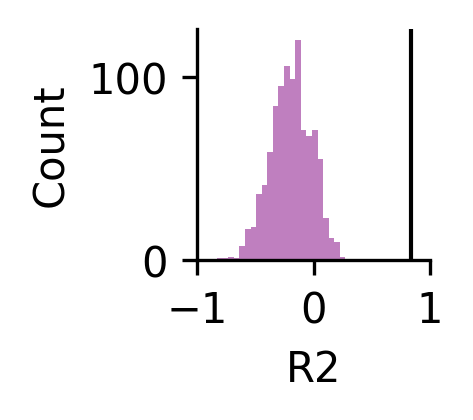

In [14]:
fig = plt.figure(figsize=(1, 1))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='purple', alpha=0.5)
ax.axvline(r2_age, color='black', lw=1)
#plt.xticks(ticks=[])
ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_regression_performance_pre.pdf')

In [15]:
## pseudo time decoder accuracy

In [16]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_pseudotime_v02.parquet')
df_psd = pd.read_parquet(path)
df_psd=df_psd.reset_index()
df_psd=df_psd[['uuid','pseudotime_rank']]
df_psd = pd.merge(data.reset_index(),df_psd,how='left',on=['uuid'])

# to convert pseudo time into bins the lengh of the bins of cross-sectional data
df_psd['bins'] = pd.qcut(df_psd['pseudotime_rank'], len(ages.unique()),labels=False)


In [17]:
# prepare data
y_psd=df_psd['bins'].to_numpy()
y_psd = [mapdr[item] for item in y_psd]
X=df_psd.filter(regex=r'\d')
#X=np.log(X+1e-6)

In [18]:
#decoder
y_pred_psd = cross_val_predict(clf, X, y_psd, cv=cv)
r2_psd = r2_score(y_psd, y_pred_psd)
mse_psd = mean_squared_error(y_psd, y_pred_psd)
print(r2_psd)
print(mse_psd)

0.9438587911364383
51.57783439490446


In [19]:
#shuffle
ysh_score_psd=[]
ysh_psd=[]
ysh_predict_psd=[]
ysh_mse_psd=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_psd)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv)
    ysh_score_psd.append(r2_score(y_psd, y_pred_temp))
    ysh_mse_psd.append(mean_squared_error(y_psd, y_pred_temp))
    ysh_psd.extend(ysh_temp)
    ysh_predict_psd.extend(y_pred_temp)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:15<00:00,  1.62it/s]


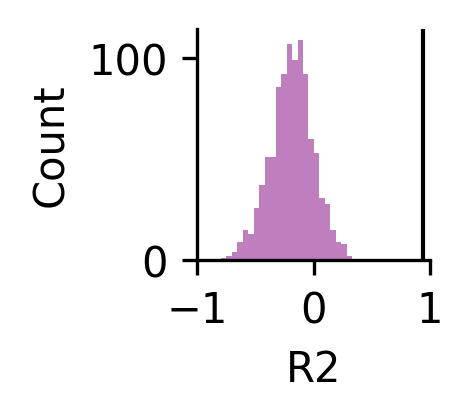

In [20]:
fig = plt.figure(figsize=(1, 1))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_psd, fill=True, element='step', lw=0, color='purple', alpha=0.5)
ax.axvline(r2_psd, color='black', lw=1)
#plt.xticks(ticks=[])
ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_regression_performance_psd.pdf')

In [21]:
## overlay both regressors performance

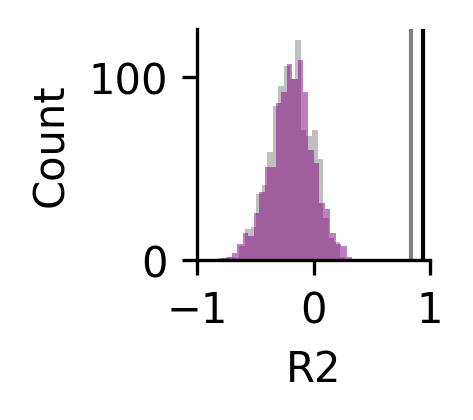

In [22]:
fig = plt.figure(figsize=(1, 1))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='grey', alpha=0.5)
ax.axvline(r2_age, color='grey', lw=1)
sns.histplot(data=ysh_score_psd, fill=True, element='step', lw=0, color='purple', alpha=0.5,ax=ax)
ax.axvline(r2_psd, color='black', lw=1)

ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_regression_performance_compare.pdf')

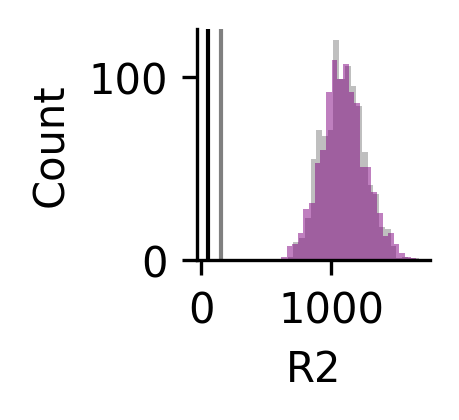

In [23]:
fig = plt.figure(figsize=(1, 1))
fig.dpi = 300
ax = sns.histplot(data=ysh_mse_age, fill=True, element='step', lw=0, color='grey', alpha=0.5)
ax.axvline(mse_age, color='grey', lw=1)
sns.histplot(data=ysh_mse_psd, fill=True, element='step', lw=0, color='purple', alpha=0.5,ax=ax)
ax.axvline(mse_psd, color='black', lw=1)

ax.set(ylabel='Count')
ax.set(xlabel='R2')
#lt.xlim([0,1.2])
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_regression_mse_compare.pdf')

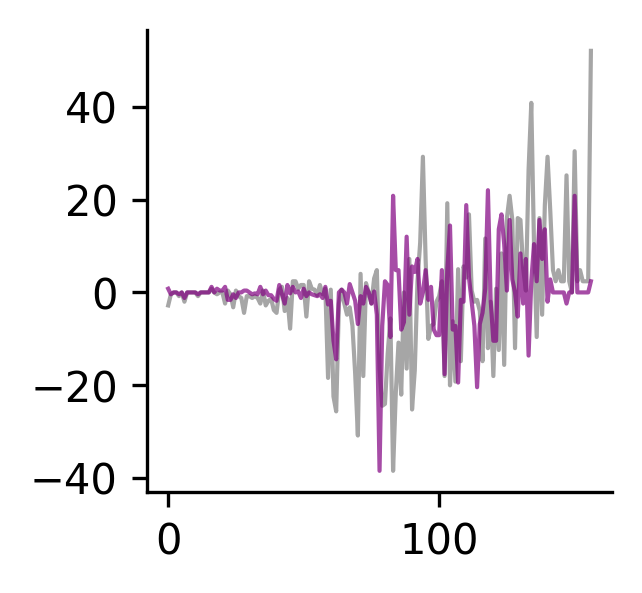

In [37]:
# plot residuals

#X=np.log(X + 1e-6) # convert to linear
res_age = y_age-y_pred
res_psd = y_psd-y_pred_psd
fig = plt.figure(figsize=(2, 2))
fig.dpi = 300
plt.plot (res_age, color='grey', lw=1, alpha=0.7)
plt.plot(res_psd, color='purple', lw=1, alpha=0.7)
#plt.ylim([-20, 5])
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_regression_residulas.pdf')

In [42]:
np.log(abs(res_age + 1e-16))

array([  1.02961942,  -0.91629073, -36.84136149, -36.84136149,
        -0.22314355, -36.84136149,   0.69314718, -36.84136149,
       -36.84136149, -36.84136149, -36.84136149,  -0.22314355,
       -36.84136149, -36.84136149, -36.84136149, -36.84136149,
        -0.22314355, -36.84136149,  -0.91629073, -36.84136149,
       -36.84136149,   0.87546874,  -0.91629073,  -0.91629073,
         1.16315081,  -0.91629073,  -0.22314355,   0.18232156,
         1.48160454,  -0.22314355,  -0.22314355,   0.18232156,
        -0.22314355,   0.18232156,   0.87546874,  -0.91629073,
         1.02961942,   0.58778666,   0.33647224,   1.33500107,
         1.48160454,  -0.51082562,   0.18232156,   1.38629436,
         0.18232156,   2.05412373,   0.87546874,   0.87546874,
        -0.22314355,   0.47000363,   0.47000363,   1.64865863,
         0.87546874,  -0.22314355,  -0.51082562,  -0.51082562,
         0.47000363,  -0.91629073,  -0.22314355,   2.91235066,
        -0.51082562,   3.10906096,   3.24259235,   0.87

In [31]:
np.log(abs(res_age) + 1e-6)

array([  1.02961977,  -0.91628823, -13.81551056, -13.81551056,
        -0.2231423 , -13.81551056,   0.69314768, -13.81551056,
       -13.81551056, -13.81551056, -13.81551056,  -0.2231423 ,
       -13.81551056, -13.81551056, -13.81551056, -13.81551056,
        -0.2231423 , -13.81551056,  -0.91628823, -13.81551056,
       -13.81551056,   0.87546915,  -0.91628823,  -0.91628823,
         1.16315112,  -0.91628823,  -0.2231423 ,   0.18232239,
         1.48160477,  -0.2231423 ,  -0.2231423 ,   0.18232239,
        -0.2231423 ,   0.18232239,   0.87546915,  -0.91628823,
         1.02961977,   0.58778722,   0.33647295,   1.33500133,
         1.48160477,  -0.51082396,   0.18232239,   1.38629461,
         0.18232239,   2.05412386,   0.87546915,   0.87546915,
        -0.2231423 ,   0.47000425,   0.47000425,   1.64865882,
         0.87546915,  -0.2231423 ,  -0.51082396,  -0.51082396,
         0.47000425,  -0.91628823,  -0.2231423 ,   2.91235072,
        -0.51082396,   3.109061  ,   3.24259239,   0.87